# Import Libraries

In [119]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd

# Data Path

In [21]:
data_path = '../data/lfw2'

# Load Dataset

## Function to load dataset information

In [43]:
def load_dataset_info(data_path):
    dataset_info = []
    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            images = os.listdir(person_dir)
            for image in images:
                dataset_info.append({"person": str(person_name), "image_path": str(os.path.join(person_dir, image))})
    return pd.DataFrame(dataset_info)

## Use the funciton to load dataset

In [44]:
dataset_df = load_dataset_info(data_path)
dataset_df.head()

,person,image_path
0,Aaron_Eckhart,../data/lfw2\Aaron_Eckhart\Aaron_Eckhart_0001.jpg
1,Aaron_Guiel,../data/lfw2\Aaron_Guiel\Aaron_Guiel_0001.jpg
2,Aaron_Patterson,../data/lfw2\Aaron_Patterson\Aaron_Patterson_0...
3,Aaron_Peirsol,../data/lfw2\Aaron_Peirsol\Aaron_Peirsol_0001.jpg
4,Aaron_Peirsol,../data/lfw2\Aaron_Peirsol\Aaron_Peirsol_0002.jpg


# Dataset Basic Overview

## Number of Total Images

In [45]:
len(dataset_df)

13233

## Number of Total Persons

In [46]:
dataset_df['person'].nunique()

5749

# Analayze Class Distribution

In [47]:
class_counts = pd.DataFrame(dataset_df['person'].value_counts())
class_counts.head(10)

,person
George_W_Bush,530
Colin_Powell,236
Tony_Blair,144
Donald_Rumsfeld,121
Gerhard_Schroeder,109
Ariel_Sharon,77
Hugo_Chavez,71
Junichiro_Koizumi,60
Jean_Chretien,55
John_Ashcroft,53


## Average Images Per Class

In [48]:
class_counts.mean()

person    2.301792
dtype: float64

## Median Images Per Class

In [49]:
class_counts.median()

person    1.0
dtype: float64

## Min Images Per Class

In [50]:
class_counts.min()

person    1
dtype: int64

## Max Images Per Class

In [51]:
class_counts.max()

person    530
dtype: int64

# Visualize Class Distribution

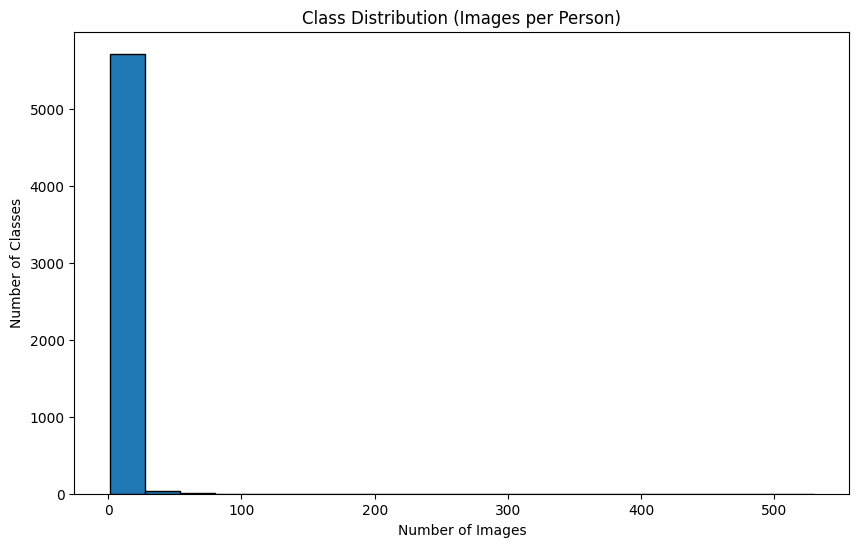

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(class_counts, bins=20, edgecolor='k')
plt.title("Class Distribution (Images per Person)")
plt.xlabel("Number of Images")
plt.ylabel("Number of Classes")
plt.show()

# View Images From Dataset

## Define Function to Plot `num_samples` images

In [96]:
def plot_sample_images(dataframe, num_samples=5):
    num_samples = min(num_samples, len(dataframe))
    images_per_row = 5
    num_rows = math.ceil(num_samples / images_per_row)

    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    axs = axs.flatten() if num_rows > 1 else [axs]

    for i, (idx, row) in enumerate(dataframe.head(num_samples).iterrows()):
        image_path = row['image_path']
        image = plt.imread(image_path)
        axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
        axs[i].axis('off')
        axs[i].set_title(row['person'], fontsize=8)

    for i in range(num_samples, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


## Ploting Images

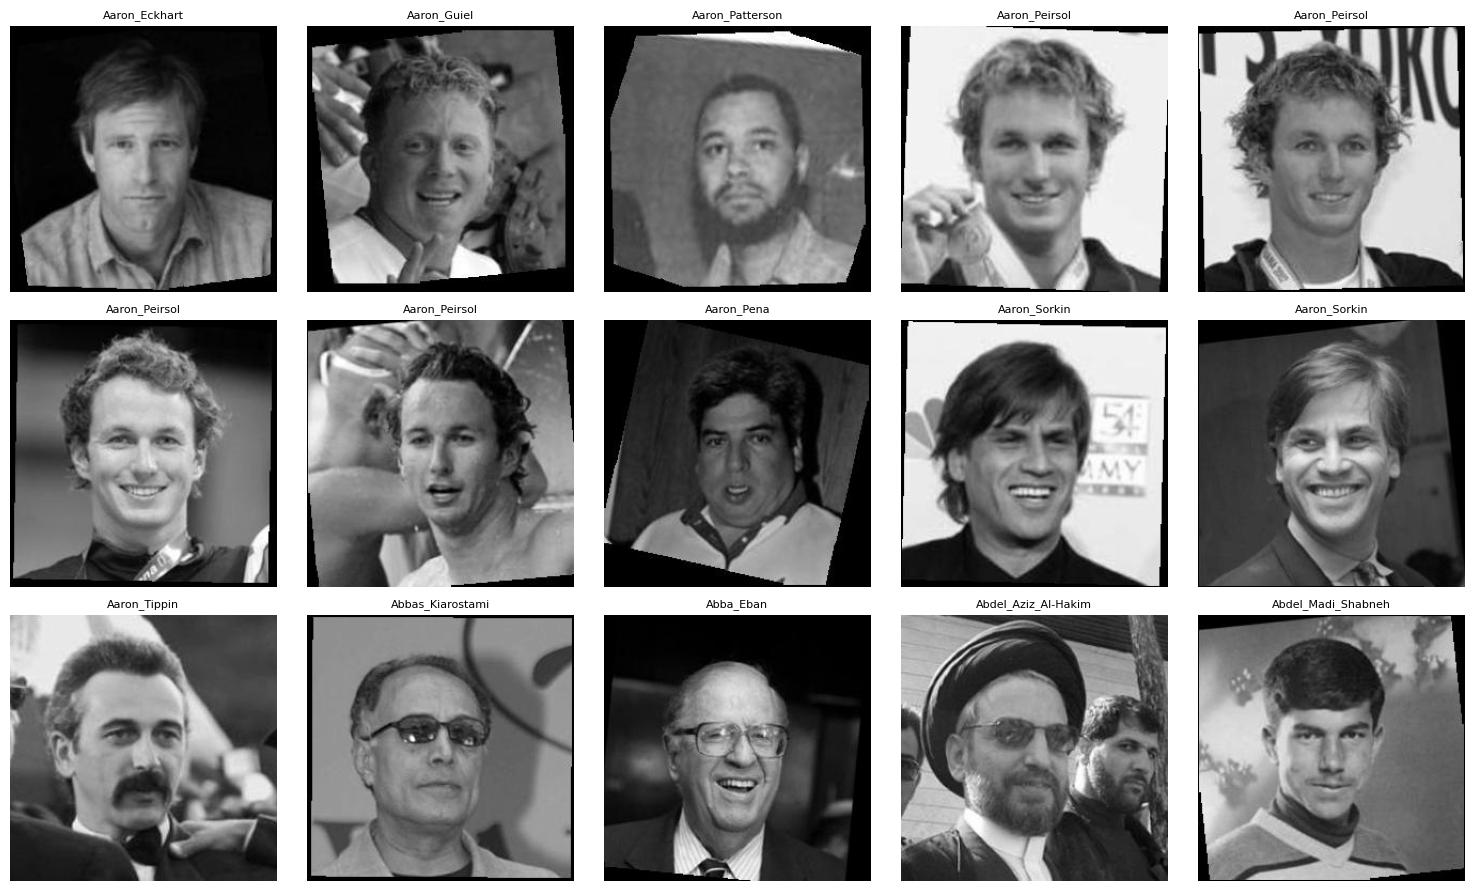

In [97]:
plot_sample_images(dataset_df, 15)

## Define Function to Plot Images of `person_name`

In [98]:
def plot_person_images(dataframe, person_name, max_images=20):
    person_df = dataframe[dataframe['person'] == person_name]

    num_images = min(max_images, len(person_df))
    images_per_row = 5
    num_rows = 1 if num_images <= images_per_row else math.ceil(num_images / images_per_row)

    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    if num_rows == 1:
        axs = axs if isinstance(axs, (list, np.ndarray)) else [axs]
    else:
        axs = axs.flatten()

    for i, (idx, row) in enumerate(person_df.head(num_images).iterrows()):
        image_path = row['image_path']
        image = plt.imread(image_path)
        axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
        axs[i].axis('off')
        axs[i].set_title(f"{row['person']}", fontsize=8)

    for i in range(num_images, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## Use The Function to Plot The Person With Most Images

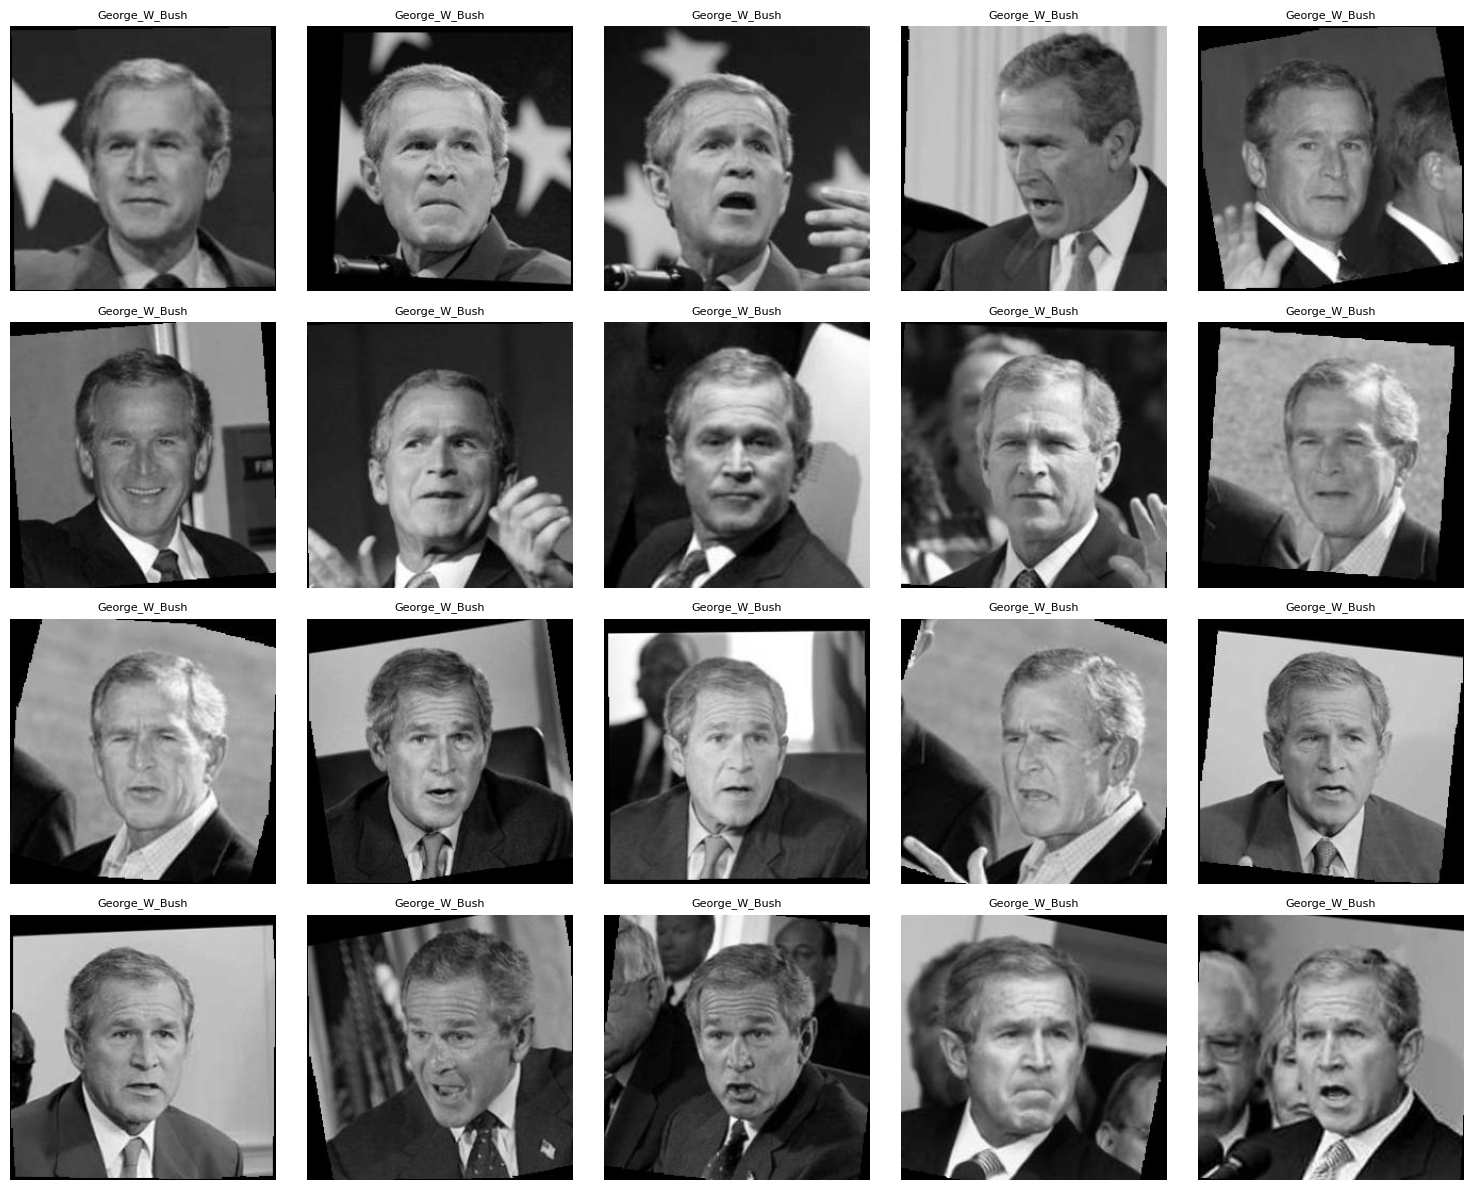

In [99]:
person_with_most_images = class_counts.idxmax()
plot_person_images(dataset_df, person_with_most_images[0])

# Split Dataset Into Train & Test

## Train & Test Text Files Paths

In [100]:
train_pairs_path = '../data/pairsDevTrain.txt'
test_pairs_path = '../data/pairsDevTest.txt'

## Function To Parse The Text Files & Load The Pairs Into Dataframes

In [101]:
def load_pairs_file(file_path, data_path):
    pairs = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        same_pairs_count = int(lines[0].strip())  
        total_pairs = len(lines) - 1

        # Process same-person pairs
        for line in lines[1:same_pairs_count + 1]:
            parts = line.strip().split()
            person_name = parts[0]
            image1_path = os.path.join(data_path, person_name, f"{person_name}_{int(parts[1]):04d}.jpg")
            image2_path = os.path.join(data_path, person_name, f"{person_name}_{int(parts[2]):04d}.jpg")
            pairs.append({
                "person1": person_name,
                "image1_path": image1_path,
                "person2": person_name,
                "image2_path": image2_path,
                "is_same": 1
            })

        # Process different-person pairs
        for line in lines[same_pairs_count + 1:]:
            parts = line.strip().split()
            person1_name = parts[0]
            image1_path = os.path.join(data_path, person1_name, f"{person1_name}_{int(parts[1]):04d}.jpg")
            person2_name = parts[2]
            image2_path = os.path.join(data_path, person2_name, f"{person2_name}_{int(parts[3]):04d}.jpg")
            pairs.append({
                "person1": person1_name,
                "image1_path": image1_path,
                "person2": person2_name,
                "image2_path": image2_path,
                "is_same": 0
            })

    return pd.DataFrame(pairs)

## Load Train & Test Dataframes

In [103]:
train_df = load_pairs_file(train_pairs_path, data_path)
test_df = load_pairs_file(test_pairs_path, data_path)

## View Train Dataset

In [113]:
train_df

,person1,image1_path,person2,image2_path,is_same
0,Aaron_Peirsol,../data/lfw2\Aaron_Peirsol\Aaron_Peirsol_0001.jpg,Aaron_Peirsol,../data/lfw2\Aaron_Peirsol\Aaron_Peirsol_0002.jpg,1
1,Aaron_Peirsol,../data/lfw2\Aaron_Peirsol\Aaron_Peirsol_0003.jpg,Aaron_Peirsol,../data/lfw2\Aaron_Peirsol\Aaron_Peirsol_0004.jpg,1
2,Aaron_Sorkin,../data/lfw2\Aaron_Sorkin\Aaron_Sorkin_0001.jpg,Aaron_Sorkin,../data/lfw2\Aaron_Sorkin\Aaron_Sorkin_0002.jpg,1
3,Abdel_Nasser_Assidi,../data/lfw2\Abdel_Nasser_Assidi\Abdel_Nasser_...,Abdel_Nasser_Assidi,../data/lfw2\Abdel_Nasser_Assidi\Abdel_Nasser_...,1
4,Abdullah,../data/lfw2\Abdullah\Abdullah_0001.jpg,Abdullah,../data/lfw2\Abdullah\Abdullah_0003.jpg,1
...,...,...,...,...,...
2195,Tom_Vilsack,../data/lfw2\Tom_Vilsack\Tom_Vilsack_0001.jpg,Wayne_Ferreira,../data/lfw2\Wayne_Ferreira\Wayne_Ferreira_000...,0
2196,Trisha_Meili,../data/lfw2\Trisha_Meili\Trisha_Meili_0001.jpg,Vladimiro_Montesinos,../data/lfw2\Vladimiro_Montesinos\Vladimiro_Mo...,0
2197,Ty_Votaw,../data/lfw2\Ty_Votaw\Ty_Votaw_0001.jpg,Wayne_Allard,../data/lfw2\Wayne_Allard\Wayne_Allard_0001.jpg,0
2198,Vytas_Danelius,../data/lfw2\Vytas_Danelius\Vytas_Danelius_000...,Zaini_Abdullah,../data/lfw2\Zaini_Abdullah\Zaini_Abdullah_000...,0


In [108]:
train_df.shape

(2200, 5)

## View Test Dataset

In [112]:
test_df

,person1,image1_path,person2,image2_path,is_same
0,Abdullah_Gul,../data/lfw2\Abdullah_Gul\Abdullah_Gul_0013.jpg,Abdullah_Gul,../data/lfw2\Abdullah_Gul\Abdullah_Gul_0014.jpg,1
1,Abdullah_Gul,../data/lfw2\Abdullah_Gul\Abdullah_Gul_0013.jpg,Abdullah_Gul,../data/lfw2\Abdullah_Gul\Abdullah_Gul_0016.jpg,1
2,Abdullatif_Sener,../data/lfw2\Abdullatif_Sener\Abdullatif_Sener...,Abdullatif_Sener,../data/lfw2\Abdullatif_Sener\Abdullatif_Sener...,1
3,Adel_Al-Jubeir,../data/lfw2\Adel_Al-Jubeir\Adel_Al-Jubeir_000...,Adel_Al-Jubeir,../data/lfw2\Adel_Al-Jubeir\Adel_Al-Jubeir_000...,1
4,Al_Pacino,../data/lfw2\Al_Pacino\Al_Pacino_0001.jpg,Al_Pacino,../data/lfw2\Al_Pacino\Al_Pacino_0002.jpg,1
...,...,...,...,...,...
995,Susan_Whelan,../data/lfw2\Susan_Whelan\Susan_Whelan_0001.jpg,Wolfgang_Schneiderhan,../data/lfw2\Wolfgang_Schneiderhan\Wolfgang_Sc...,0
996,Takeo_Fukui,../data/lfw2\Takeo_Fukui\Takeo_Fukui_0001.jpg,Will_Ofenheusle,../data/lfw2\Will_Ofenheusle\Will_Ofenheusle_0...,0
997,Tamara_Mowry,../data/lfw2\Tamara_Mowry\Tamara_Mowry_0001.jpg,Zach_Parise,../data/lfw2\Zach_Parise\Zach_Parise_0001.jpg,0
998,Tatiana_Kennedy_Schlossberg,../data/lfw2\Tatiana_Kennedy_Schlossberg\Tatia...,Thomas_Watjen,../data/lfw2\Thomas_Watjen\Thomas_Watjen_0001.jpg,0


In [109]:
test_df.shape

(1000, 5)

# EDA on Train Dataframe

## Check For Missing Values

In [115]:
missing_values = train_df.isnull().sum()
missing_values

person1        0
image1_path    0
person2        0
image2_path    0
is_same        0
dtype: int64

## Distribution of `is_same` value

In [121]:
label_counts = train_df['is_same'].value_counts()
label_counts

1    1100
0    1100
Name: is_same, dtype: int64

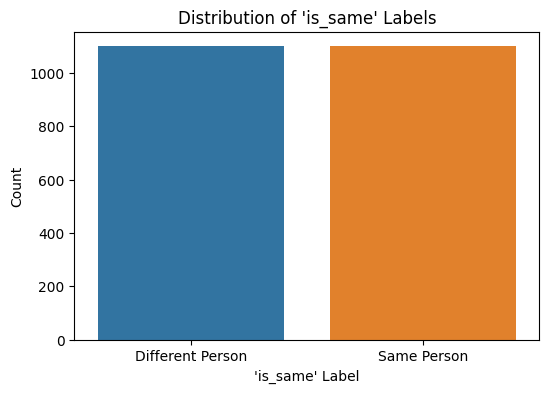

In [125]:
plt.figure(figsize=(6, 4))
sns.barplot(
    x=label_counts.index, 
    y=label_counts.values, 
    hue=label_counts.index,
    dodge=False,  
    legend=False 
)
plt.title("Distribution of 'is_same' Labels")
plt.xlabel("'is_same' Label")
plt.ylabel("Count")
plt.xticks([0, 1], ['Different Person', 'Same Person'])
plt.show()

## Unique Individuals

In [127]:
unique_persons = set(train_df['person1']).union(set(train_df['person2']))
len(unique_persons)

2132

## Count Occurrences Of Each Individual

In [135]:
X = 10
person_counts = Counter(train_df['person1']) + Counter(train_df['person2'])
most_common_persons = person_counts.most_common(X)
print(f"\nTop {X} Individuals with the Most Pairs:")
for person, count in most_common_persons:
    print(f"{person}: {count} pairs")


Top 10 Individuals with the Most Pairs:
Alec_Baldwin: 10 pairs
Angelina_Jolie: 10 pairs
Catherine_Zeta-Jones: 10 pairs
Jason_Kidd: 10 pairs
Ana_Guevara: 9 pairs
Ari_Fleischer: 9 pairs
Bob_Graham: 9 pairs
Jennifer_Garner: 9 pairs
Paul_Wolfowitz: 9 pairs
Zhu_Rongji: 9 pairs


## Distribution of Person Appearances

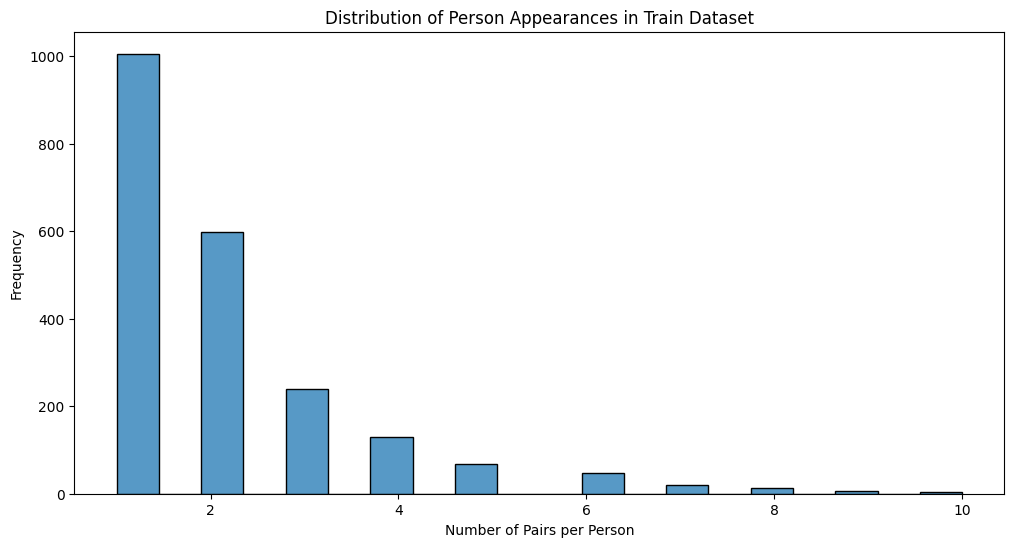

In [140]:
person_counts = Counter(train_df['person1']) + Counter(train_df['person2'])
person_counts_df = pd.DataFrame(person_counts.items(), columns=["person", "count"])
person_counts_df = person_counts_df.sort_values(by="count", ascending=False)

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(person_counts_df['count'], bins=20, kde=False)
plt.title("Distribution of Person Appearances in Train Dataset")
plt.xlabel("Number of Pairs per Person")
plt.ylabel("Frequency")
plt.show()

## Total Unique Pairs

In [143]:
total_unique_pairs = len(train_df[['image1_path', 'image2_path']].drop_duplicates())
total_unique_pairs

2200

## Individuals With The Most Same-Person Pairs

In [146]:
same_person_pairs = pd.DataFrame(train_df[train_df['is_same'] == 1]['person1'].value_counts())
same_person_pairs.head(5)

,person1
Angelina_Jolie,5
Jason_Kidd,5
Catherine_Zeta-Jones,5
Alec_Baldwin,4
John_Snow,4
